Pickle file read

In [2]:
import pickle
import numpy as np

data_file = "data/valid_set/2891.pkl"

with open(data_file, 'rb') as file:
    seq_data = pickle.load(file)

for sequence, data in seq_data.items():
    barcodes = data['barcodes']
    #embeddings = data['embeddings']
    label_MF = data['label_MF']
    label_BP = data['label_BP']
    label_CC = data['label_CC']

try:
    barcodes = np.array(barcodes)
except ValueError:
    for idx, el in enumerate(barcodes):
        cur = len(el)
        if idx > 0:
            diff = cur - prev
            if diff < 0:
                for _ in range(-diff):
                    barcodes[idx].append([0, 0, 0])
            elif diff > 0:
                for _ in range(diff):
                    barcodes[idx].append([0, 0, 0])
        prev = len(el)
    barcodes = np.array(barcodes)
label_MF = np.array(label_MF)
label_CC = np.array(label_CC)
label_BP = np.array(label_BP)

In [3]:
barcodes.shape, label_BP.shape, label_CC.shape, label_MF.shape

((660, 306, 3), (1943,), (320,), (489,))

Example of Persistence Image usage

In [4]:
from gudhi.representations import PersistenceImage
from gudhi.representations import DiagramSelector
import matplotlib.pyplot as plt

pds  = DiagramSelector(use=True).fit_transform(barcodes)
vpdtr = np.vstack(pds)

pers = vpdtr[:,1]-vpdtr[:,0]
im_bnds = [np.min(vpdtr[:,0]), 0.05, 0.8, np.max(pers)]
PI_params = {'bandwidth': 8e-3, 'weight': lambda x: x[1], 
                 'resolution': [50,50], 'im_range': im_bnds}
image = PersistenceImage(**PI_params).fit_transform(pds)

In [ ]:
#print(pds[0])

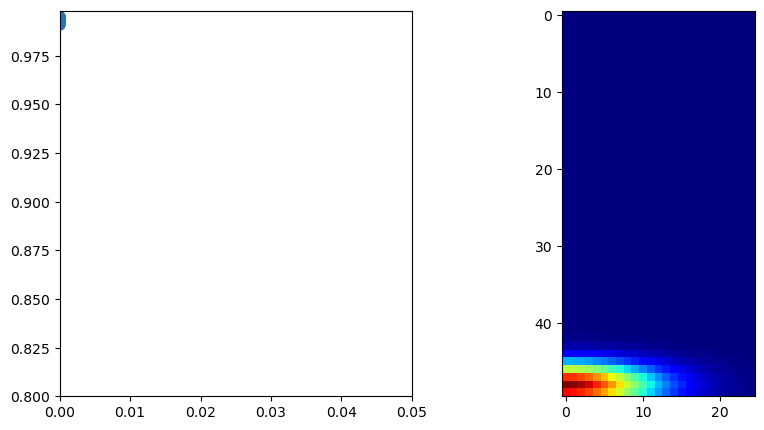

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_idx = 15
birth = barcodes[plot_idx][:, 0]
death = barcodes[plot_idx][:, 1]
ax[0].scatter(birth, death)
ax[0].set_ylim(im_bnds[-2], im_bnds[-1])
ax[0].set_xlim(im_bnds[0], im_bnds[1])
ax[1].imshow(np.reshape(image[plot_idx], [50,50])[:, :25], cmap='jet')

In [153]:
from gudhi.representations import PersistenceImage
from gudhi.representations import DiagramSelector
import os
import numpy as np
import pickle

def get_per_im(barcodes):
    pds  = DiagramSelector(use=True).fit_transform(barcodes)
    vpdtr = np.vstack(pds)

    pers = vpdtr[:,1] - vpdtr[:,0]
    im_bnds = [np.min(vpdtr[:,0]), 0.05, 0.8, np.max(pers)]
    PI_params = {'bandwidth': 8e-3, 'weight': lambda x: x[1], 
                 'resolution': [50,50], 'im_range': im_bnds}
    # print(f'pds[0]: {pds[0]}')
    # print(im_bnds)
    image = PersistenceImage(**PI_params).fit_transform(pds)
    return image

def read_one_file(file_path, barcodes = True, labels = False):
    with open(file_path, 'rb') as file:
        seq_data = pickle.load(file)
    for sequence, data in seq_data.items():
        if barcodes:
            barcodes = data['barcodes']
        if labels:
            label_MF = data['label_MF']
            label_BP = data['label_BP']
            label_CC = data['label_CC']
    ans = {}
    if barcodes:
        barcodes = np.array(barcodes)
        PI = get_per_im(barcodes)
        ans['images'] = PI
    if labels:
        label_MF = np.array(label_MF)
        label_CC = np.array(label_CC)
        label_BP = np.array(label_BP)
        ans['MF'] = label_MF
        ans['CC'] = label_CC
        ans['BP'] = label_BP
    return ans

def clear():
    os.system('cls' if os.name == 'nt' else 'clear')

def read_all_files(dir_path, output_dir, barcodes=True, labels=False, verbose=True):
    files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
    total_files = len(files)
    print(files[431:441])
    exit()
    for i, filename in enumerate(files, start=1):
        file_path = os.path.join(dir_path, filename)
        result = read_one_file(file_path, barcodes=barcodes, labels=labels)
        
        base_name = os.path.splitext(filename)[0]
        output_file_path = os.path.join(output_dir, f"{base_name}.npz")
        np.savez(output_file_path, **result)

        if verbose:
            if i % 10 == 0:
                print(f"Current file is {i} out of {total_files}")
            if i % 200 == 0:
                clear()

In [154]:
test_one = read_one_file("data/valid_set/1000.pkl", labels=True)

In [39]:
test_string = '2254.pkl'
int(test_string[:-4])

2254

In [8]:
def plot_images_in_batches(images, batch_size=10):
    """
    Generator function to plot images in batches.

    Args:
    - images: numpy array of images
    - batch_size: number of images to plot at a time

    Yields:
    - Plots images in batches
    """
    total_images = images.shape[0]
    for start_idx in range(0, total_images, batch_size):
        end_idx = min(start_idx + batch_size, total_images)
        print(start_idx, end_idx)
        yield images[start_idx:end_idx]

# Example usage
def plot_next_batch(image_generator, figsize=(20, 10)):
    try:
        batch_images = next(image_generator)
        fig, axes = plt.subplots(1, len(batch_images), figsize=figsize)
        for i, image in enumerate(batch_images):
            axes[i].imshow(np.reshape(image, [50, 50]), cmap='jet')
            axes[i].axis('off')  # Hide axes
        plt.show()
    except StopIteration:
        print("No more images to display.")

0 6


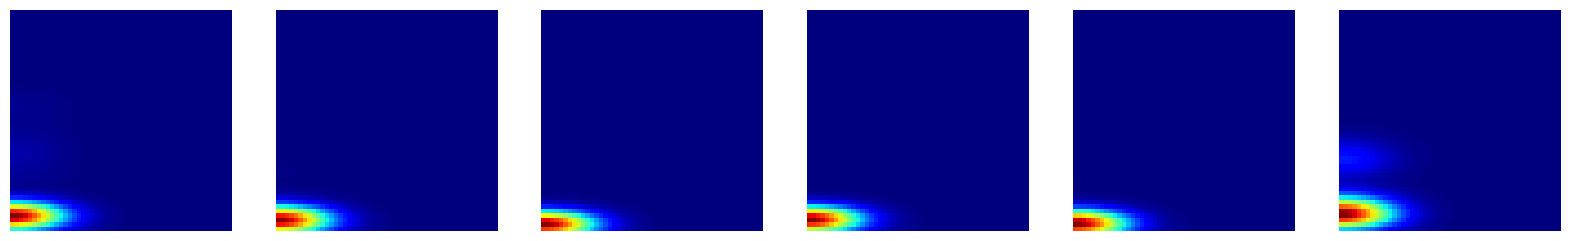

In [155]:
image_gen = plot_images_in_batches(test_one['images'], batch_size=6)

plot_next_batch(image_gen)

In [ ]:
read_all_files('data/valid_set', 'data/testing_directory')

In [165]:
test_d = np.load('./data/testing_directory/0.npz', allow_pickle=True)
test_d['images'].shape

(660, 2500)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
ax.imshow(np.reshape(test_d['images'][0], [50,50]), cmap='jet')